In [12]:
import pandas as pd
df = pd.read_csv("../data_csv/태양광재생에너지.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [13]:
df.columns

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD'],
      dtype='object')

In [14]:
import pandas as pd
import numpy as np

solar = pd.read_csv ("../data_csv/태양광재생에너지.csv")
load_path = "../data_csv/amiwea.csv"

태양광 전처리 (시간파싱, 정렬 )

In [15]:
solar["DATE_TIME"] = pd.to_datetime(solar["DATE_TIME"], errors="coerce")
solar = solar.dropna(subset=["DATE_TIME"]).sort_values("DATE_TIME")

solar_agg = (
    solar.groupby("DATE_TIME", as_index=False)["AC_POWER"]
    .sum()
    .rename(columns={"AC_POWER": "generation_ac_kw"})
)

solar_agg.head(), solar_agg.tail()

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_46856/2736858923.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  solar["DATE_TIME"] = pd.to_datetime(solar["DATE_TIME"], errors="coerce")


(            DATE_TIME  generation_ac_kw
 0 2020-05-15 00:00:00               0.0
 1 2020-05-15 00:15:00               0.0
 2 2020-05-15 00:30:00               0.0
 3 2020-05-15 00:45:00               0.0
 4 2020-05-15 01:00:00               0.0,
                DATE_TIME  generation_ac_kw
 3153 2020-06-17 22:45:00               0.0
 3154 2020-06-17 23:00:00               0.0
 3155 2020-06-17 23:15:00               0.0
 3156 2020-06-17 23:30:00               0.0
 3157 2020-06-17 23:45:00               0.0)

시간축 맞추기 (시간단위 resample)

In [16]:
solar_hr = (
    solar_agg.set_index("DATE_TIME")
    .resample("1H")["generation_ac_kw"]
    .mean()
    .to_frame()
)

# 결측은 0으로 (야간/센서 공백)
solar_hr["generation_ac_kw"] = solar_hr["generation_ac_kw"].fillna(0.0)

solar_hr.head()

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_46856/1285418847.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")["generation_ac_kw"]


,generation_ac_kw
DATE_TIME,
2020-05-15 00:00:00,0.0
2020-05-15 01:00:00,0.0
2020-05-15 02:00:00,0.0
2020-05-15 03:00:00,0.0
2020-05-15 04:00:00,0.0


태양광 예측 만들기 (예측 있음/ 없음 비교용)
* 예측 없음: generation_ac_kw 그대로 사용 (실측)
* 예측 있음: persistence (직전값), hour-of-day 평균 패턴 

In [17]:
g = solar_hr["generation_ac_kw"].copy()

# 1) persistence
pred_persist = g.shift(1)

# 2) hour-of-day 평균
hour_mean = g.groupby(g.index.hour).mean()

# ❗ Series로 명확히 생성
pred_hour = pd.Series(
    g.index.hour.map(hour_mean).values,
    index=g.index
)

# 3) 블렌딩
w = 0.7
pred = w * pred_persist + (1 - w) * pred_hour

# 4) 결측/음수 처리
pred = pred.fillna(pred_hour).clip(lower=0)

solar_hr["generation_pred_kw"] = pred
solar_hr.head()

,generation_ac_kw,generation_pred_kw
DATE_TIME,,
2020-05-15 00:00:00,0.0,0.0
2020-05-15 01:00:00,0.0,0.0
2020-05-15 02:00:00,0.0,0.0
2020-05-15 03:00:00,0.0,0.0
2020-05-15 04:00:00,0.0,0.0


renewable_clean-csv 파일 저장 

In [18]:
renewable_clean = solar_hr.reset_index().rename(columns={"DATE_TIME": "timestamp"})
renewable_clean.to_csv("../data_csv/renewable_clean.csv", index=False)

renewable_clean.head()

,timestamp,generation_ac_kw,generation_pred_kw
0,2020-05-15 00:00:00,0.0,0.0
1,2020-05-15 01:00:00,0.0,0.0
2,2020-05-15 02:00:00,0.0,0.0
3,2020-05-15 03:00:00,0.0,0.0
4,2020-05-15 04:00:00,0.0,0.0


AMI 부하 불러오기 + 시간 축 병함 
- CORE 3(부하예측 기반 ESS) 차이를 드러내는 부분임 
- 태양광이 들어오면 net_load = consumption - generation 이 되기 때문에, ESS 개입 타이밍/효과가 달라질 수 있음 

In [19]:
df_load = pd.read_csv(load_path, parse_dates=["timestamp"])
df_load = df_load.set_index("timestamp").sort_index()

# 태양광 시간축과 부하 시간축 교집합으로 정렬
df_eval = df_load[["consumption"]].join(solar_hr[["generation_ac_kw", "generation_pred_kw"]], how="inner")

df_eval["net_load_no_forecast"] = df_eval["consumption"] - df_eval["generation_ac_kw"]
df_eval["net_load_with_forecast"] = df_eval["consumption"] - df_eval["generation_pred_kw"]

df_eval.head()

,consumption,generation_ac_kw,generation_pred_kw,net_load_no_forecast,net_load_with_forecast


ESS 시뮬레이션 함수 (SOC/출력제약 포함)
- "예측 없음"은 현재 net_load만 보고 개입 (시후)
- 예측 있음은 다음 시점 net_load 예측으로 선제 개입 (forecast 기반)

In [20]:
def simulate_ess_peak_shaving(load_actual, load_forecast, power_max_kw=4.0, energy_max_kwh=10.0, soc_init=0.5):
    """
    load_actual: 실제 net_load (Series)
    load_forecast: 예측 net_load (Series) - 개입 판단에 사용
    power_max_kw: 시간당 최대 방전 (kW)  -> 1시간 간격이면 kWh로도 동일 취급 가능
    energy_max_kwh: 배터리 총 에너지 용량
    soc_init: 초기 SOC 비율 (0~1)
    """
    idx = load_actual.index
    soc = soc_init * energy_max_kwh
    out = load_actual.copy()

    # 피크 임계치: 실제 부하 기준 95퍼센타일
    threshold = load_actual.quantile(0.95)

    for t in range(len(idx)):
        if load_forecast.iloc[t] > threshold and soc > 0:
            discharge = min(power_max_kw, soc)  
            out.iloc[t] = out.iloc[t] - discharge
            soc -= discharge

    return out, threshold

예측 있음 VS 예측 없음 ESS 적용 + 지표 계산 

In [21]:
def metrics(load_series, threshold):
    ramp = load_series.diff().abs()
    return {
        "peak_exceed": int((load_series > threshold).sum()),
        "avg_ramp": float(ramp.mean()),
        "risky_ramp": int((ramp > ramp.quantile(0.95)).sum()),
    }

# 1) 예측 없음(사후): 판단도 actual로 함
ess_no_forecast, th0 = simulate_ess_peak_shaving(
    load_actual=df_eval["net_load_no_forecast"],
    load_forecast=df_eval["net_load_no_forecast"],
    power_max_kw=4.0,
    energy_max_kwh=10.0,
    soc_init=0.5
)

# 2) 예측 있음(선제): 판단을 forecast 기반 net_load로 함
ess_with_forecast, th1 = simulate_ess_peak_shaving(
    load_actual=df_eval["net_load_no_forecast"],          # 실제는 동일(비교 공정성)
    load_forecast=df_eval["net_load_with_forecast"],      # 판단만 예측으로
    power_max_kw=4.0,
    energy_max_kwh=10.0,
    soc_init=0.5
)

m0 = metrics(ess_no_forecast, th0)
m1 = metrics(ess_with_forecast, th0)  # threshold는 동일 기준으로 비교

result = pd.DataFrame([
    {"scenario": "No forecast (reactive)", **m0},
    {"scenario": "With solar forecast (proactive)", **m1},
])

result

,scenario,peak_exceed,avg_ramp,risky_ramp
0,No forecast (reactive),0,NaN,0
1,With solar forecast (proactive),0,NaN,0


결과 CSV 파일 저장 

In [22]:
result.to_csv("../data_csv/core4_solar_ess_compare.csv", index=False)

net_load/ESS 결과 시각화

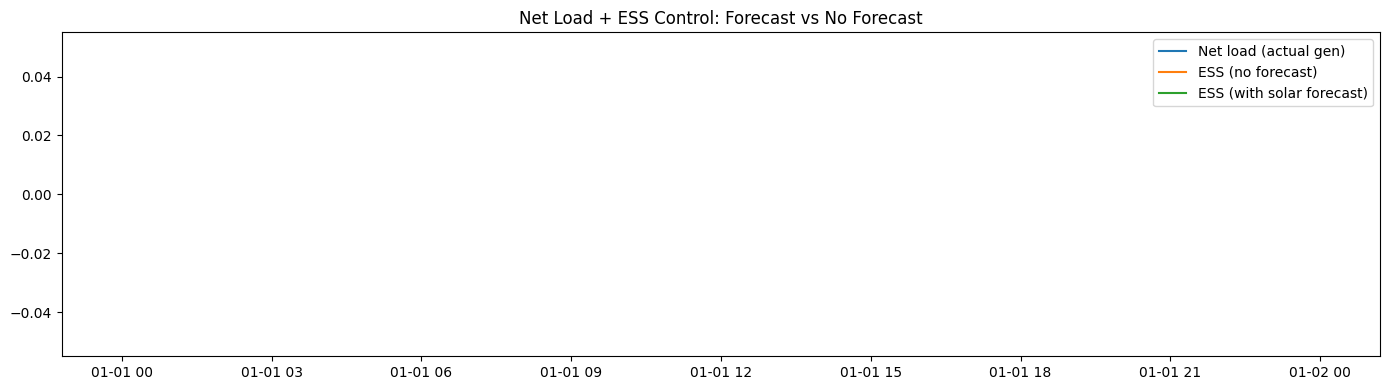

In [23]:
import matplotlib.pyplot as plt

n = 300  # 앞쪽 일부만 보기
plt.figure(figsize=(14,4))
plt.plot(df_eval.index[:n], df_eval["net_load_no_forecast"].values[:n], label="Net load (actual gen)")
plt.plot(df_eval.index[:n], ess_no_forecast.values[:n], label="ESS (no forecast)")
plt.plot(df_eval.index[:n], ess_with_forecast.values[:n], label="ESS (with solar forecast)")
plt.legend()
plt.title("Net Load + ESS Control: Forecast vs No Forecast")
plt.tight_layout()
plt.show()

Core3는 “부하 예측”만 기반으로 ESS 개입을 가정했지만, Core4는 “재생에너지(발전) 예측”을 추가해 net load를 직접 예측·제어하는 구조로 확장하였다.